<font size=5 >Credit Card Approval Prediction Using Sklearn</font>

<h1>Table of Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Response-Variable" data-toc-modified-id="Response-Variable-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Response Variable</a></span></li><li><span><a href="#Features" data-toc-modified-id="Features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Features</a></span><ul class="toc-item"><li><span><a href="#Binary-Features" data-toc-modified-id="Binary-Features-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Binary Features</a></span><ul class="toc-item"><li><span><a href="#Gender" data-toc-modified-id="Gender-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Gender</a></span></li><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Categorical Features</a></span><ul class="toc-item"><li><span><a href="#Algorithms" data-toc-modified-id="Algorithms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Algorithms</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Xgboost" data-toc-modified-id="Xgboost-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Xgboost</a></span></li><li><span><a href="#Keras-Neural-Networks" data-toc-modified-id="Keras-Neural-Networks-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Keras Neural Networks</a></span></li></ul></li></ul></div>

In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [2]:
# plt.rcParams['figure.facecolor'] = 'white'

### Binary Features

In [3]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Feature Engineering

In [4]:
def return_no(x):
    if x==None:
        return "No"

def data_preprocessing(data):

    ## Feature Engineering
    # find all users' account open month.
    begin_month=pd.DataFrame(data.groupby(["ID"])["Vintage"].agg(min))
    begin_month=begin_month.rename(columns={'Vintage':'begin_month'}) 
    new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

    del begin_month

    ##Generally, users in risk should be in 3%, thus I choose users who overdue for more than 60 days as target risk users. Those samples are marked as '1', else are '0'.
    new_data['target']=data['Is_Active']
    new_data.loc[new_data['target']=='Yes','target']=1
    new_data.loc[new_data['target']=='No','target']=0
    print(new_data['target'].value_counts())
    new_data['target'].value_counts(normalize=True)
    
    #features
#     new_data.dropna()
#     new_data = new_data.mask(new_data == 'NULL').dropna()

    ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
    ivtable['IV']=None

    
#     for col in columns:
#         try:
# #             new_data[col].replace(np.NaN, new_data[col].mean())        
#             new_data[col].replace(None, new_data[col].mean())            
#         except:pass
    
    #No     144357, Yes     72043
    new_data['Credit_Product'] = new_data['Credit_Product'].apply(lambda x: return_no(x))


    from sklearn.preprocessing import LabelEncoder

    label_encoder = LabelEncoder()

    l_encoder = label_encoder.fit(new_data['Gender'])
    new_data['Gender'] = l_encoder.transform(new_data['Gender'])
    
    l_encoder = label_encoder.fit(new_data['Region_Code'])
    new_data['Region_Code'] = l_encoder.transform(new_data['Region_Code'])

    l_encoder = label_encoder.fit(new_data['Occupation'])
    new_data['Occupation'] = l_encoder.transform(new_data['Occupation'])

    l_encoder = label_encoder.fit(new_data['Channel_Code'])
    new_data['Channel_Code'] = l_encoder.transform(new_data['Channel_Code'])

    l_encoder = label_encoder.fit(new_data['Credit_Product'])
    new_data['Credit_Product'] = l_encoder.transform(new_data['Credit_Product'])

#     l_encoder = label_encoder.fit(new_data['Is_Active'])
#     new_data['Is_Active'] = l_encoder.transform(new_data['Is_Active'])

    del label_encoder, l_encoder
    
    
#     print(data['Is_Active'].value_counts())
#     data['Is_Active'].value_counts(normalize=True)
    
    #Gender
    print(new_data['Gender'].value_counts())
    iv, data = calc_iv(new_data,'Gender','target')
    ivtable.loc[ivtable['variable']=='Gender','IV']=iv

    #Avg_Account_Balance
#     new_data['Avg_Account_Balance']=new_data['Avg_Account_Balance'].astype(object)
#     new_data['Avg_Account_Balance'] = new_data['Avg_Account_Balance']/10000     
    new_data['Avg_Account_Balance'] = new_data['Avg_Account_Balance'].apply(lambda x: x/10000)

    print(new_data['Avg_Account_Balance'].value_counts(bins=10,sort=False))
    new_data['Avg_Account_Balance'].plot(kind='hist',bins=50,density=True)  
       
    return new_data

0    150290
1     95435
Name: target, dtype: int64
1    134197
0    111528
Name: Gender, dtype: int64
This variable's IV is: 0.01743281354405051
1    134197
0    111528
Name: Gender, dtype: int64
(1.0450000000000002, 105.391]    148577
(105.391, 208.703]                73815
(208.703, 312.016]                15340
(312.016, 415.328]                 4834
(415.328, 518.64]                  1585
(518.64, 621.952]                   738
(621.952, 725.264]                  418
(725.264, 828.577]                  282
(828.577, 931.889]                  125
(931.889, 1035.201]                  11
Name: Avg_Account_Balance, dtype: int64
Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'begin_month', 'target'],
      dtype='object')


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,begin_month,target
0,NNVBBKZB,0,73,18,1,2,43,0,104.5696,No,0,43,0
1,IDD62UNG,0,30,27,2,0,32,0,58.1988,No,0,32,0
2,HD3DSEMC,0,56,18,3,2,26,0,148.4315,Yes,0,26,1
3,BF3NC7KV,1,34,20,2,0,19,0,47.0454,No,0,19,0
4,TEASRWXV,0,30,32,2,0,33,0,88.6787,No,0,33,0


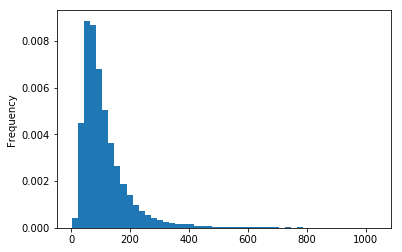

In [5]:
new_data = data_preprocessing(pd.read_csv("../input/jobathon-may-2021/train.csv", encoding = 'utf-8') )

print(new_data.columns)
new_data.head()

0    63797
1    41515
Name: target, dtype: int64
1    57705
0    47607
Name: Gender, dtype: int64
This variable's IV is: 0.020052086601170444
1    57705
0    47607
Name: Gender, dtype: int64
(1.27, 101.122]       60798
(101.122, 199.985]    33196
(199.985, 298.848]     7263
(298.848, 397.71]      2343
(397.71, 496.573]       872
(496.573, 595.435]      396
(595.435, 694.298]      201
(694.298, 793.161]      152
(793.161, 892.023]       63
(892.023, 990.886]       28
Name: Avg_Account_Balance, dtype: int64


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,begin_month,target
0,VBENBARO,1,29,4,1,0,25,0,74.2366,No,25,0
1,CCMEWNKY,1,43,18,1,1,49,0,92.5537,No,49,0
2,VK3KGA9M,1,31,20,2,0,14,0,21.5949,No,14,0
3,TT8RPZVC,1,29,22,1,0,33,0,86.8070,No,33,0
4,SHQZEYTZ,0,29,20,1,0,19,0,65.7087,No,19,0


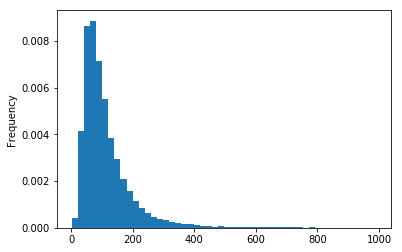

In [6]:
test_data = data_preprocessing(pd.read_csv("../input/jobathon-may-2021/test.csv", encoding = 'utf-8') )
test_data.head()

# Algorithms

In [7]:
Y = new_data['Is_Lead']
X = new_data[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 
    'Credit_Product', 'Avg_Account_Balance', 'target', 'begin_month']]
X.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Credit_Product,Avg_Account_Balance,target,begin_month
0,0,73,18,1,2,0,104.5696,0,43
1,0,30,27,2,0,0,58.1988,0,32
2,0,56,18,3,2,0,148.4315,1,26
3,1,34,20,2,0,0,47.0454,0,19
4,0,30,32,2,0,0,88.6787,0,33


+ Using Synthetic Minority Over-Sampling Technique(`SMOTE`) to overcome sample imbalance problem.

In [8]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_sample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

+ After over sampling, the number between 1 and 0 is balanced. It can be seen from the confusion matrix.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, test_size=0.2,
                                                    random_state = 10086)
print(X_train.size, X_test.size, y_train.size, y_test.size)

2699091 674775 299899 74975


## Logistic Regression   

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

In [10]:
# model = LogisticRegression(C=0.8,
#                            random_state=0,
#                            solver='lbfgs')
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)

# print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

# sns.set_style('white') 
# class_names = ['0','1']
# plot_confusion_matrix(confusion_matrix(y_test,y_predict),
#                       classes= class_names, normalize = True, 
#                       title='Normalized Confusion Matrix: Logistic Regression')


## Decision Tree

In [11]:
# model = DecisionTreeClassifier(max_depth=12,
#                                min_samples_split=8,
#                                random_state=1024)
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)

# print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

# plot_confusion_matrix(confusion_matrix(y_test,y_predict),
#                       classes=class_names, normalize = True, 
#                       title='Normalized Confusion Matrix: CART')

## Random Forest   

In [12]:
# model = RandomForestClassifier(n_estimators=250,
#                               max_depth=12,
#                               min_samples_leaf=16
#                               )
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)

# print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

# plot_confusion_matrix(confusion_matrix(y_test,y_predict),
#                       classes=class_names, normalize = True, 
#                       title='Normalized Confusion Matrix: Ramdom Forests')

## SVM


<!-- <center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://i.loli.net/2019/11/13/fryWG5al7OPHDiA.gif">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Support Vector Machine</div>
</center> -->

In [13]:
# model = svm.SVC(C = 0.8,
#                 kernel='linear')
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)

# print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

# plot_confusion_matrix(confusion_matrix(y_test,y_predict),
#                       classes=class_names, normalize = True, 
#                       title='Normalized Confusion Matrix: SVM')

## LightGBM

In [14]:
# model = LGBMClassifier(num_leaves=31,
#                        max_depth=8, 
#                        learning_rate=0.02,
#                        n_estimators=250,
#                        subsample = 0.8,
#                        colsample_bytree =0.8
#                       )
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)
# print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

In [15]:
# submisson = pd.DataFrame()

# submisson['ID'] = test_data['ID']
# test_data_temp = test_data[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
#        'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'begin_month', 'target']]

# submisson['Is_Lead'] = model.predict(test_data_temp)
# submisson.to_csv('sample_submission.csv')
# submisson.head()

Showing important features:

In [16]:
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance', 
    ylabel='features')
    
# plot_importance(model, X_train,20)   



In [17]:
# print(model.booster_.feature_importance(importance_type='gain'))

## Xgboost

[0]	validation_0-auc:0.906367
Will train until validation_0-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.908923
[2]	validation_0-auc:0.909655
[3]	validation_0-auc:0.909875
[4]	validation_0-auc:0.910589
[5]	validation_0-auc:0.910542
[6]	validation_0-auc:0.910711
[7]	validation_0-auc:0.910832
[8]	validation_0-auc:0.911081
[9]	validation_0-auc:0.911471
[10]	validation_0-auc:0.911584
[11]	validation_0-auc:0.911648
[12]	validation_0-auc:0.911733
[13]	validation_0-auc:0.91202
[14]	validation_0-auc:0.911995
[15]	validation_0-auc:0.911937
[16]	validation_0-auc:0.912135
[17]	validation_0-auc:0.9122
[18]	validation_0-auc:0.912219
[19]	validation_0-auc:0.912248
[20]	validation_0-auc:0.912326
[21]	validation_0-auc:0.912389
[22]	validation_0-auc:0.912448
[23]	validation_0-auc:0.912509
[24]	validation_0-auc:0.912508
[25]	validation_0-auc:0.912541
[26]	validation_0-auc:0.912561
[27]	validation_0-auc:0.912595
[28]	validation_0-auc:0.912642
[29]	validation_0-auc:0.912702
[30]	validation_0-a

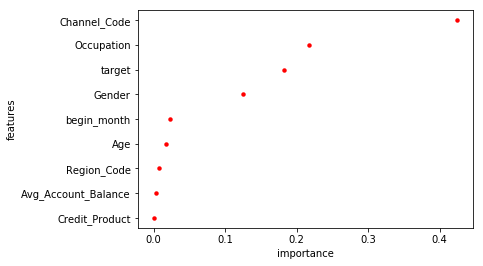

In [18]:
model = XGBClassifier(max_depth=12,
                      n_estimators=400,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.01,    
                      seed=42)

eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=25, eval_metric="auc", eval_set=eval_set, verbose=True)

y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_importance(model, X_train, 20)   

## CatBoost

In [19]:
# model = CatBoostClassifier(iterations=250,
#                            learning_rate=0.2,
#                            od_type='Iter',
#                            verbose=25,
#                            depth=16,
#                            random_seed=42)

# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)
# print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
# print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

### >>> roc_auc_score(y, clf.predict_proba(X)[:, 1])

In [24]:
submisson = pd.DataFrame()

submisson['ID'] = test_data['ID']
test_data_temp = test_data[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Credit_Product', 'Avg_Account_Balance', 'target', 'begin_month']]

submisson['Is_Lead'] = model.predict(test_data_temp)

submisson.to_csv('sample_submission.csv', index=False)
submisson.head()

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0


## Building the Keras neural networks
After a good deal of trial and error, I found that a network architecture with three hidden layers, each followed by a dropout layer of rate 0.3, was as good as I could find. I used ReLU activation in those hidden layers, and adam optimization and a loss metric of mean squared error in the model as a whole. I also settled on a mean squared logarithmic error loss function, since it performed better than mean absolute error, mean squared error, and mean absolute percentage error.

The dataset being so large, I had great results increasing the batch size for the first couple models.


In [21]:
# from sklearn.model_selection import train_test_split
# from sklearn_pandas import DataFrameMapper
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
# from tensorflow.keras import Sequential, Input
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping



# def run_pipeline(batch_size):
    
#     input_nodes = X_train.shape[1]
#     output_nodes = 1

#     model = Sequential()
#     model.add(Input((input_nodes,)))
#     model.add(Dense(32, activation="sigmoid"))
#     model.add(Dropout(0.4, seed=0))
#     model.add(Dense(16, activation="sigmoid"))
#     model.add(Dropout(0.4, seed=1))
#     model.add(Dense(8, activation="sigmoid"))
#     model.add(Dropout(0.4, seed=2))
#     model.add(Dense(output_nodes, activation='sigmoid'))
#     model.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])

#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)

#     history = model.fit(
#         X_train,
#         y_train,
#         batch_size=batch_size,
#         epochs=500,
#         validation_data=(X_test, y_test),
#         verbose=2,
#         callbacks=[es]
#     )

#     return history.history, model

In [22]:
# print("Model 1:")
# history_1, model1 = run_pipeline(batch_size=1024*10)

In [23]:
# submisson = pd.DataFrame()

# submisson['ID'] = test_data['ID']
# test_data_temp = test_data[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
#        'Credit_Product', 'Avg_Account_Balance', 'target', 'begin_month']]

# submisson['Is_Lead'] = model1.predict(test_data_temp)

# submisson.to_csv('sample_submission.csv', index=False)
# submisson.head()